In [ ]:
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l

     |████████████████████████████████| 711.0MB 26kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://d2l.ai/whl.html
     |████████████████████████████████| 51kB 5.9MB/s 


# AutoRec: Rating Prediction with Autoencoders

Although the matrix factorization model achieves decent performance on the rating prediction task, it is essentially a linear model. Thus, such models are not capable of capturing complex nonlinear and intricate relationships that may be predictive of users' preferences. In this section, we introduce a nonlinear neural network collaborative filtering model, AutoRec :cite:`Sedhain.Menon.Sanner.ea.2015`. It identifies collaborative filtering (CF) with an autoencoder architecture and aims to integrate nonlinear transformations into CF on the basis of explicit feedback. Neural networks have been proven to be capable of approximating any continuous function, making it suitable to address the limitation of matrix factorization and enrich the expressiveness of matrix factorization.

On one hand, AutoRec has the same structure as an autoencoder which consists of an input layer, a hidden layer, and a reconstruction (output) layer.  An autoencoder is a neural network that learns to copy its input to its output in order to code the inputs into the hidden (and usually low-dimensional) representations. In AutoRec, instead of explicitly embedding users/items into low-dimensional space, it uses the column/row of the interaction matrix as the input, then reconstructs the interaction matrix in the output layer.

On the other hand, AutoRec differs from a traditional autoencoder: rather than learning the hidden representations, AutoRec focuses on learning/reconstructing the output layer. It uses a partially observed interaction matrix as the input, aiming to reconstruct a completed rating matrix. In the meantime, the missing entries of the input are filled in the output layer via reconstruction for the purpose of recommendation. 

There are two variants of AutoRec: user-based and item-based. For brevity, here we only introduce the item-based AutoRec. User-based AutoRec can be derived accordingly.


## Model

Let $\mathbf{R}_{*i}$ denote the $i^\mathrm{th}$ column of the rating matrix, where unknown ratings are set to zeros by default. The neural architecture is defined as:

$$
h(\mathbf{R}_{*i}) = f(\mathbf{W} \cdot g(\mathbf{V} \mathbf{R}_{*i} + \mu) + b)
$$

where $f(\cdot)$ and $g(\cdot)$ represent activation functions, $\mathbf{W}$ and $\mathbf{V}$ are weight matrices, $\mu$ and $b$ are biases. Let $h( \cdot )$ denote the whole network of AutoRec. The output $h(\mathbf{R}_{*i})$ is the reconstruction of the $i^\mathrm{th}$ column of the rating matrix.

The following objective function aims to minimize the reconstruction error:

$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{R}_{*i} - h(\mathbf{R}_{*i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$

where $\| \cdot \|_{\mathcal{O}}$ means only the contribution of observed ratings are considered, that is, only weights that are associated with observed inputs are updated during back-propagation.

In [ ]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
import mxnet as mx
import sys

import pandas as pd
import io
npx.set_np()

## Implementing the Model

A typical autoencoder consists of an encoder and a decoder. The encoder projects the input to hidden representations and the decoder maps the hidden layer to the reconstruction layer. We follow this practice and create the encoder and decoder with dense layers. The activation of encoder is set to `sigmoid` by default and no activation is applied for decoder. Dropout is included after the encoding transformation to reduce over-fitting. The gradients of unobserved inputs are masked out to ensure that only observed ratings contribute to the model learning process.

In [ ]:
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # mask the gradient during training.
            return pred * np.sign(input)
        else:
            return pred

## Reimplementing the Evaluator

Since the input and output have been changed, we need to reimplement the evaluation function, while we still use RMSE as the accuracy measure.

In [ ]:
def evaluator(network, inter_matrix, test_data, ctx):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, ctx, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE.
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

## Training and Evaluating the Model

Now, let us train and evaluate AutoRec on the MovieLens dataset. We can clearly see that the test RMSE is lower than the matrix factorization model, confirming the effectiveness of neural networks in the rating prediction task.

In [ ]:
ctx = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
num_workers = 0 if sys.platform.startswith("win") else 4
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(np.array(train_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=num_workers)
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=ctx, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        ctx, evaluator, inter_mat=test_inter_mat)

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
uploaded3 = files.upload()

Saving transaction_all2_2_samplesize.csv to transaction_all2_2_samplesize (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded3['transaction_all2_2_samplesize.csv']), sep=',')
#df2 = df.values

In [ ]:
df.head()

,customer_id,merchant_id,rating,timestamp,customer_id_map,mechant_id_map
0,1000000,1000004,1.0,1559779200,1,1
1,1000000,1000009,1.0,1566345600,1,2
2,1000000,1000036,1.0,1559952000,1,3
3,1000000,1000069,1.0,1557792000,1,4
4,1000000,1000126,1.0,1550448000,1,5


In [ ]:
df.shape

(3000, 6)

In [ ]:
df['customer_id'].nunique()

19

In [ ]:
df['merchant_id'].nunique()

1920

In [ ]:
ctx = d2l.try_all_gpus()

In [ ]:
test_ratio = 0.1
mx.random.seed(128)
mask = [True if x == 1 else False for x in np.random.uniform(
    0, 1, (len(df))) < 1 - test_ratio]
neg_mask = [not x for x in mask]
train_data2, test_data2 = df[mask], df[neg_mask]

In [ ]:
train_indices = [i for i, x in enumerate(mask) if x == True]
len(train_indices)

2725

In [ ]:
train_indices[1:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
test_indices = [i for i, x in enumerate(neg_mask) if x == True]
len(test_indices)

275

In [ ]:
test_indices[1:10]

[21, 30, 36, 39, 56, 66, 80, 85, 88]

In [ ]:
# train_data2['customer_id'].nunique(),train_data2['merchant_id'].nunique()
# test_data2['customer_id'].nunique(),test_data2['merchant_id'].nunique()

In [ ]:
test_data2.reset_index(drop=True,inplace=True)
train_data2.reset_index(drop=True,inplace=True)

In [ ]:
test_data2 = test_data2[['customer_id_map', 'mechant_id_map', 'rating', 'timestamp']]
train_data2 = train_data2[['customer_id_map', 'mechant_id_map', 'rating', 'timestamp']]

In [ ]:
test_data2 = test_data2[['user_id', 'item_id', 'rating', 'timestamp']]
train_data2 = train_data2[['user_id', 'item_id', 'rating', 'timestamp']]

In [ ]:
train_data2[(train_data2["mechant_id_map"] == 249)]

In [ ]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        user_index_list, item_index_list = int(line[1]), int(line[2])
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index_list)
        items.append(item_index_list)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [ ]:
users_train, items_train, scores_train, train_inter_mat = load_data_ml100k(train_data2, 19,
                                                 1920)
users_test, items_test, scores_test, test_inter_mat = load_data_ml100k(test_data2, 19,
                                                1920)

In [ ]:
for i,value in enumerate(train_inter_mat):
    print(i,value)

In [ ]:
# test_inter_mat.shape
# x = test_inter_mat.asnumpy()
# x.shape
# x[0], len(x[0])
# len(x.nonzero()[0]),len(x.nonzero()[1])

In [ ]:
num_workers = 0 if sys.platform.startswith("win") else 4
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=num_workers)
test_iter = gluon.data.DataLoader(np.array(test_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=num_workers)

In [ ]:
net = AutoRec(500, 19)
net.initialize(ctx=ctx, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
#d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
#                        ctx, evaluator, inter_mat=test_inter_mat)

train loss 0.000, test RMSE 0.069
1273312.2 examples/sec on [gpu(0)]


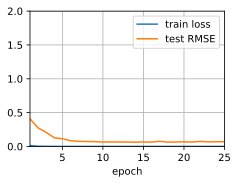

In [ ]:
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        ctx, evaluator, inter_mat=test_inter_mat)

In [ ]:
for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, ctx))
            train_feat = input_data[0:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(ctx)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            

In [ ]:
scores = []
count = 0 
for values in test_iter:
    count = count+1
    print(count)
    print(len(values))
    feat = gluon.utils.split_and_load(values, ctx, even_split=False)
    print(feat)
    for i in feat:
      print(i[0])
    scores.extend([net(i).asnumpy() for i in feat])
    print("****************")
print("scores",scores)
print("****************")
print("len of scores",len(scores))
recons = np.array([item for sublist in scores for item in sublist])
# Calculate the test RMSE.
print(len(recons))
print(np.sign(test_inter_mat))
rmse = np.sqrt(np.sum(np.square(test_inter_mat - np.sign(test_inter_mat)*recons))
                / np.sum(np.sign(test_inter_mat)))
print(rmse)

1
1024
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], ctx=gpu(0))]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] @gpu(0)
****************
2
896
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], ctx=gpu(0))]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] @gpu(0)
****************
scores [array([[1.017109  , 0.9940266 , 0.9742635 , ..., 0.94374883, 0.9881141 ,
        0.8623952 ],
       [1.0164353 , 0.9984136 , 0.97248685, ..., 0.94141465, 0.98752993,
        0.8617897 ],
       [1.017109  , 0.9940266 , 0.9742635 , ..., 0.94374883, 0.9881141 ,
        0.8623952 ],
       ...,
       

In [ ]:
for i,value in enumerate(recons):
    print(i,value)

Streaming output truncated to the last 5000 lines.
 0.9931506  0.9733754  1.0329548  1.0138447  1.0027276  0.995612
 0.94473225 1.0134833  0.9137153  1.0052655  0.9420152  0.9887449
 0.86256176]
671 [1.017109   0.9940266  0.9742635  0.9507506  1.0007792  1.0548564
 0.9920854  0.9737364  1.026913   1.0137469  1.0039694  0.9953873
 0.94537264 1.0128379  0.9205778  1.0048305  0.94374883 0.9881141
 0.8623952 ]
672 [1.017109   0.9940266  0.9742635  0.9507506  1.0007792  1.0548564
 0.9920854  0.9737364  1.026913   1.0137469  1.0039694  0.9953873
 0.94537264 1.0128379  0.9205778  1.0048305  0.94374883 0.9881141
 0.8623952 ]
673 [1.017109   0.9940266  0.9742635  0.9507506  1.0007792  1.0548564
 0.9920854  0.9737364  1.026913   1.0137469  1.0039694  0.9953873
 0.94537264 1.0128379  0.9205778  1.0048305  0.94374883 0.9881141
 0.8623952 ]
674 [1.017109   0.9940266  0.9742635  0.9507506  1.0007792  1.0548564
 0.9920854  0.9737364  1.026913   1.0137469  1.0039694  0.9953873
 0.94537264 1.0128379  0

In [ ]:
df.rating.value_counts()

1.000000    2293
1.121951     319
1.243902     169
1.365854      88
1.487805      51
1.609756      28
1.731707      15
1.853659      12
1.975610       7
2.097561       6
2.219512       4
2.341463       2
2.585366       1
2.463415       1
2.951220       1
2.829268       1
2.707317       1
3.317073       1
Name: rating, dtype: int64

In [ ]:
test_data2.head()

,customer_id_map,mechant_id_map,rating,timestamp
0,1,13,1.00000,1546560000
1,1,22,1.00000,1550016000
2,1,31,1.00000,1559001600
3,1,37,1.00000,1577059200
4,1,40,1.97561,1568851200


In [ ]:
test_data2.shape

(275, 4)

In [ ]:
test_cust_merchant_list = test_data2[["customer_id_map","mechant_id_map"]].apply(tuple, axis=1)
test_cust_merchant_list

0         (1, 13)
1         (1, 22)
2         (1, 31)
3         (1, 37)
4         (1, 40)
          ...    
270    (18, 1120)
271    (18, 1906)
272    (18, 1916)
273    (19, 1917)
274    (19, 1918)
Length: 275, dtype: object

In [ ]:
pred_list = []
for i,j in test_cust_merchant_list:
  rating_list = [i,j,
                test_inter_mat[(j-1),(i-1)],
                recons[(j-1),(i-1)]
        ]
  pred_details = dict(zip(('customer_id_map','mechant_id_map','actual_rating','pred_rating'), rating_list))
  pred_list.append(pred_details)
pred_df = pd.DataFrame(pred_list)

In [ ]:
pred_df

In [ ]:
pred_df['actual_rating'].value_counts()

1.0    273
1.0      1
2.0      1
Name: actual_rating, dtype: int64

In [ ]:
pred_df[pred_df['actual_rating'] == 2]

,customer_id_map,mechant_id_map,actual_rating,pred_rating
216,14,460,2.0,0.993704


## Summary

* We can frame the matrix factorization algorithm with autoencoders, while integrating non-linear layers and dropout regularization. 
* Experiments on the MovieLens 100K dataset show that AutoRec achieves superior performance than matrix factorization.